In [1]:
import numpy as np
import random 
from tqdm import tqdm

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn

import matplotlib.pyplot as plt

### Import Data ###

In [2]:
#MNIST Dataset
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 40354503.27it/s]


Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw



100%|██████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 21696029.33it/s]


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw



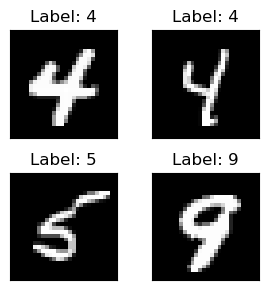

In [3]:
#Visualize Data
fig, axs = plt.subplots(2, 2, figsize=(3,3))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=512

train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

### Encoder and Decoder ###

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

NameError: name 'nn' is not defined

In [6]:
class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x
     

In [7]:
d = 4
encoder = Encoder(encoded_space_dim=d)
decoder = Decoder(encoded_space_dim=d)

### Train ###

In [8]:
loss_fn = torch.nn.MSELoss()
lr= 0.001
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [9]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:

        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)

        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [10]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)

            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [11]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]


 EPOCH 0/15 	 train loss 0.171 	 val loss 0.131


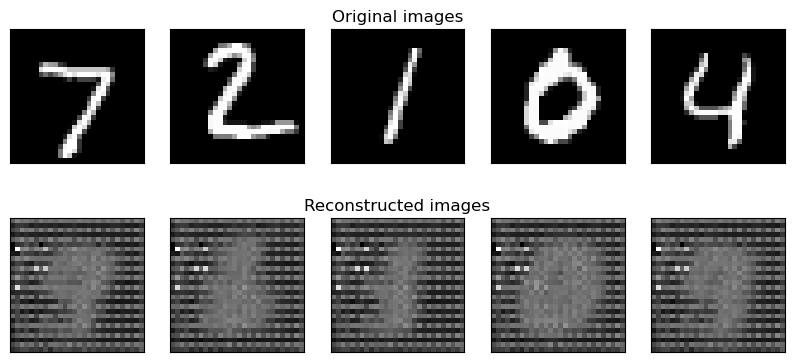

 13%|███████████                                                                        | 2/15 [00:16<01:44,  8.01s/it]


 EPOCH 1/15 	 train loss 0.102 	 val loss 0.079


 20%|████████████████▌                                                                  | 3/15 [00:23<01:29,  7.43s/it]


 EPOCH 2/15 	 train loss 0.065 	 val loss 0.054


 27%|██████████████████████▏                                                            | 4/15 [00:29<01:18,  7.13s/it]


 EPOCH 3/15 	 train loss 0.048 	 val loss 0.043

 EPOCH 4/15 	 train loss 0.040 	 val loss 0.038


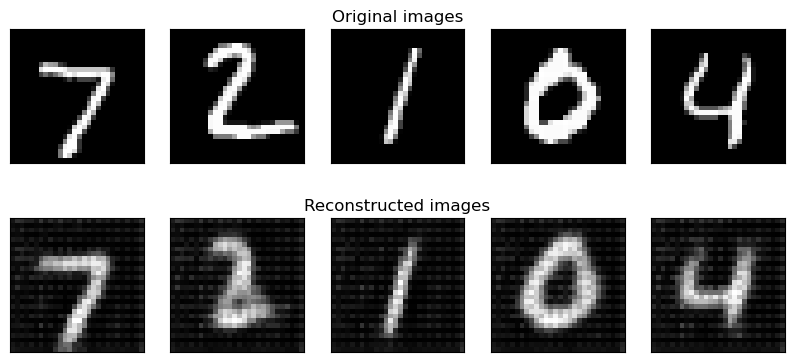

 40%|█████████████████████████████████▏                                                 | 6/15 [00:43<01:03,  7.02s/it]


 EPOCH 5/15 	 train loss 0.036 	 val loss 0.035


 47%|██████████████████████████████████████▋                                            | 7/15 [00:51<00:57,  7.14s/it]


 EPOCH 6/15 	 train loss 0.034 	 val loss 0.033


 53%|████████████████████████████████████████████▎                                      | 8/15 [00:58<00:50,  7.18s/it]


 EPOCH 7/15 	 train loss 0.032 	 val loss 0.032

 EPOCH 8/15 	 train loss 0.031 	 val loss 0.031


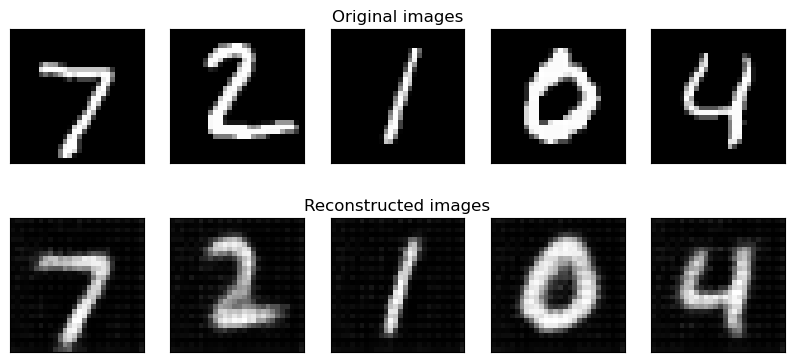

 67%|██████████████████████████████████████████████████████▋                           | 10/15 [01:13<00:36,  7.29s/it]


 EPOCH 9/15 	 train loss 0.031 	 val loss 0.031


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [01:20<00:29,  7.37s/it]


 EPOCH 10/15 	 train loss 0.030 	 val loss 0.030


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [01:28<00:22,  7.40s/it]


 EPOCH 11/15 	 train loss 0.030 	 val loss 0.030

 EPOCH 12/15 	 train loss 0.029 	 val loss 0.030


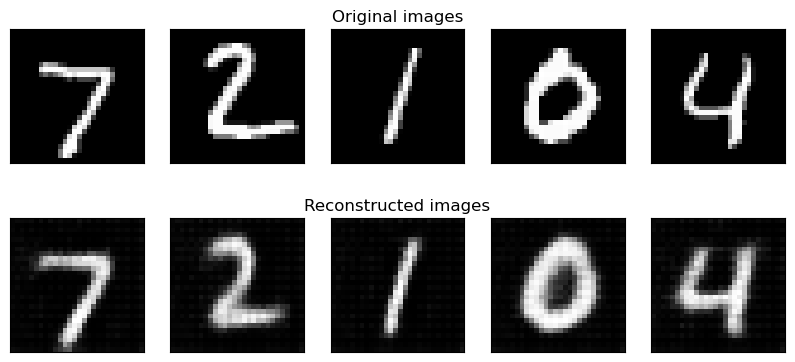

 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [01:42<00:07,  7.18s/it]


 EPOCH 13/15 	 train loss 0.029 	 val loss 0.029


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [01:49<00:00,  7.27s/it]


 EPOCH 14/15 	 train loss 0.029 	 val loss 0.029


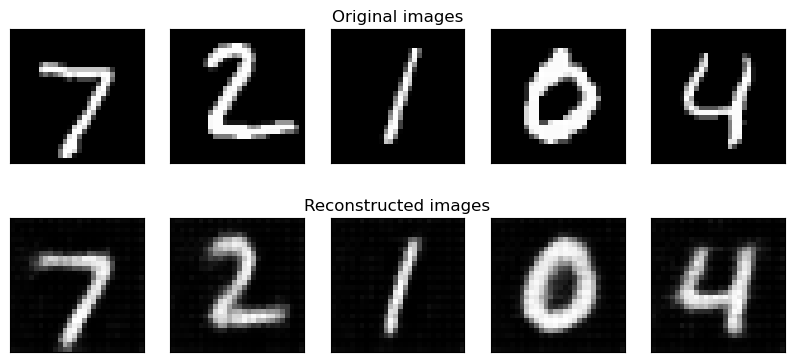

In [12]:
num_epochs = 15
print_frequency = 4
for epoch in tqdm(range(num_epochs)):
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch, num_epochs,train_loss,val_loss))
   if epoch % print_frequency == 0:
      plot_ae_outputs(encoder,decoder,n=5)

plot_ae_outputs(encoder,decoder,n=5)